## Bibliotecas

In [2]:
#-*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from modules.analytics import DataGovAnalysis
from unidecode import unidecode
from datetime import datetime

In [2]:
DataAnalysis = DataGovAnalysis(csv_file = 'data/compras_dt_vr_preprocessed_sorted.csv')

Loading Data...
Preparing Data...


In [3]:
DataAnalysis.df.shape

(4444022, 6)

In [4]:
DataAnalysis.df.head()

,id,vr_estimado,year,month,day,dates
124369,174551,78000.0,2000,1,3,2000-01-03
124370,415025,840.0,2000,1,3,2000-01-03
124371,34541,6439.0,2000,1,3,2000-01-03
124372,110061,2585.0,2000,1,3,2000-01-03
124373,376770,3610.0,2000,1,3,2000-01-03


In [5]:
DataAnalysis.df.vr_estimado.describe()

count    4.444022e+06
mean     8.429231e+04
std      1.154624e+07
min      0.000000e+00
25%      4.800000e+02
50%      1.400000e+03
75%      4.000000e+03
max      1.800000e+10
Name: vr_estimado, dtype: float64

## Encontrando os 100 maiores gastos

In [3]:
csv_file = 'data/compras_slicitacoes.csv'
original_df = pd.read_csv(csv_file)

In [4]:
df = original_df[(original_df.dtDeclaracaoDispensa >= '2000-01-01')]

In [5]:
df['dtDeclaracaoDispensa'] = pd.to_datetime(df.dtDeclaracaoDispensa)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df.shape

(4444022, 17)

In [7]:
df = df[df.vr_estimado > 0]
df.shape

(4342439, 17)

In [8]:
del original_df

In [9]:
dt_vr = df[['dtDeclaracaoDispensa', 'vr_estimado']]

In [178]:
Query1_A = dt_vr.groupby(by = [dt_vr.dtDeclaracaoDispensa.dt.month]).mean()
Query1_A = Query1_A.reset_index()
Query1_A.columns = ['Mês', 'Gastos']
Query1_A.to_csv('resultado_query1.csv')


Query1_B = dt_vr.groupby(by = [dt_vr.dtDeclaracaoDispensa.dt.year, dt_vr.dtDeclaracaoDispensa.dt.month]).mean()
Query1_B.index.rename('Mês',level=1,inplace=True)
Query1_B.index.rename('Ano',level=0,inplace=True)
Query1_B = Query1_B.reset_index()
Query1_B.columns = ['Ano', 'Mês', 'Gastos']
Query1_B.head()

,Ano,Mês,Gastos
0,2000,1,115937.685282
1,2000,2,23495.945035
2,2000,3,13888.612671
3,2000,4,21472.792350
4,2000,5,86616.990162


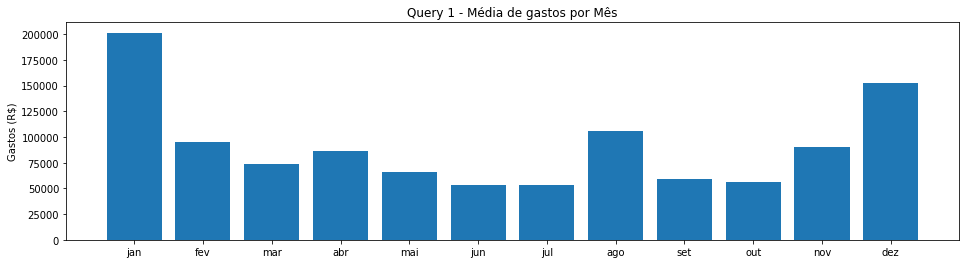

In [179]:
plt.figure(figsize=(16,4))
plt.bar(['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez'], Query1_A['Gastos'])
plt.title('Query 1 - Média de gastos por Mês')
plt.ylabel('Gastos (R$)')
plt.savefig('Query1.png')

In [152]:
uasg_vr = df[['co_uasg', 'vr_estimado']]
uasgs = pd.read_csv('data/uasgs.csv')

localidades = pd.read_csv('data/municipios.csv')
localidades.head()

,Unnamed: 0,ativo,id,nome,nome_uf,sigla_uf
0,0,True,19,Guajará-Mirim,RONDÔNIA,RO
1,1,True,27,ALTO ALEGRE DOS PARECIS,RONDÔNIA,RO
2,2,True,35,Porto Velho,RONDÔNIA,RO
3,3,True,43,BURITIS,RONDÔNIA,RO
4,4,True,51,Ji-Paraná,RONDÔNIA,RO


In [153]:
uasgs = pd.merge(left=uasgs[['id', 'id_municipio', 'nome']], left_on='id_municipio', right = localidades[['id', 'nome', 'sigla_uf']], right_on='id')
uasgs = uasgs.drop(['id_municipio'], axis = 1)
uasgs.columns = ['id', 'nome', 'id_municipio', 'Município', 'UF']
uasgs = uasgs.drop_duplicates('id')
uasgs.head()

,id,nome,id_municipio,Município,UF
0,10001,CAMARA DOS DEPUTADOS,97012,BRASÍLIA,DF
2,10002,CAMARA DOS DEPUTADOS - UG P/CONSULTA,97012,BRASÍLIA,DF
4,10090,FUNDO ROTATIVO DA CAMARA DOS DEPUTADOS,97012,BRASÍLIA,DF
6,20001,SENADO FEDERAL,97012,BRASÍLIA,DF
8,20002,CENTRO GRAFICO DO SENADO FEDERAL,97012,BRASÍLIA,DF


In [156]:
uasg_vr = pd.merge(left=uasgs, left_on='id', right=uasg_vr, right_on='co_uasg')

In [176]:
Query2 = uasg_vr.groupby(by = ['id_municipio', 'Município', 'UF'])[['vr_estimado']].sum()
Query2 = Query2.sort_values(by = 'vr_estimado', ascending = False)
Query2 = Query2.reset_index()
Query2.columns = ['id_Municipio', 'Cidade', 'UF', 'Gastos']
Query2 = Query2.drop('id_Municipio', axis = 1)
Query2.to_csv('resultado_query2.csv')
Query2.head()

,Cidade,UF,Gastos
0,BRASÍLIA,DF,2.183212e+11
1,Rio de Janeiro,RJ,5.289779e+10
2,Porto Alegre,RS,2.251428e+10
3,Belém,PA,7.531324e+09
4,Belo Horizonte,MG,6.591175e+09


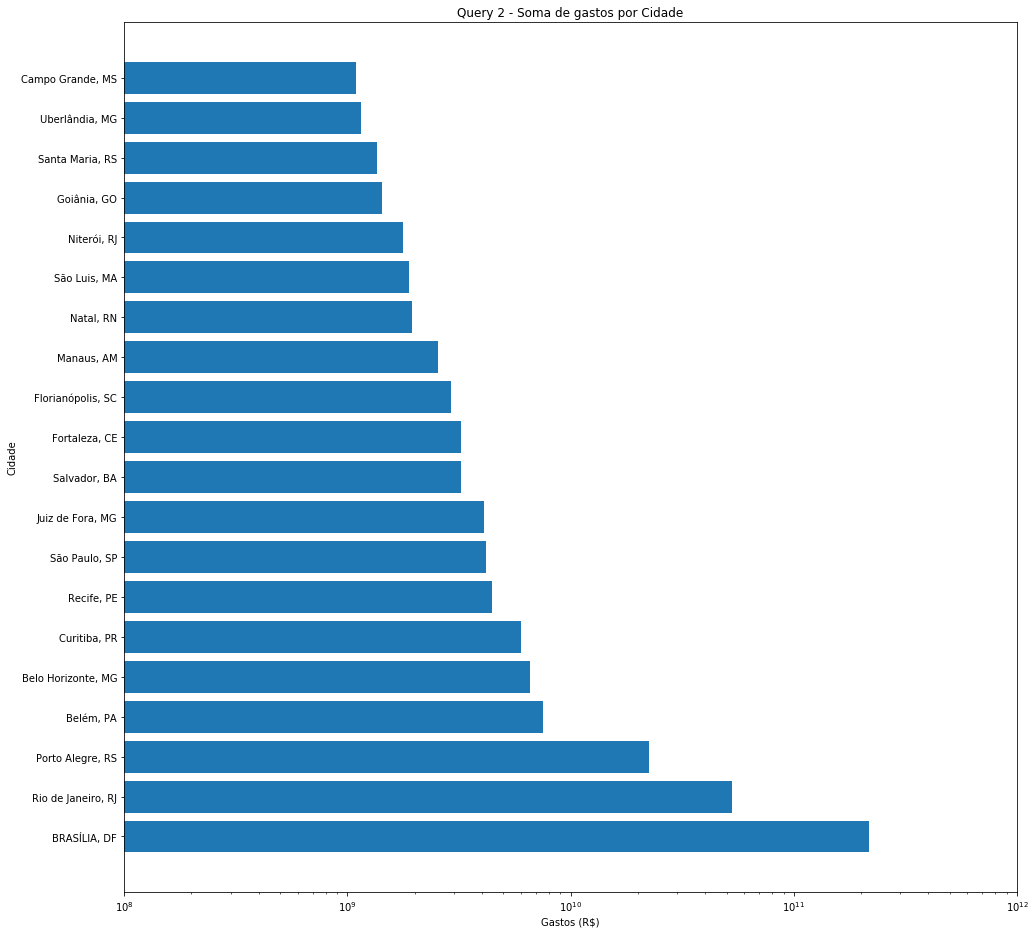

In [177]:
plt.figure(figsize=(16,16))
plt.barh(Query2['Cidade'].values[0:20] + ', ' + Query2.UF.values[0:20], Query2.Gastos.values[0:20])
plt.title('Query 2 - Soma de gastos por Cidade')
plt.xlabel('Gastos (R$)')
plt.ylabel('Cidade')
plt.xscale('log')
plt.xlim(1e8,1e12)
plt.savefig('Query2.png')

In [200]:
md_vr = df[['dtDeclaracaoDispensa', 'co_modalidade_licitacao','vr_estimado']]
Query3 = md_vr.groupby([md_vr.dtDeclaracaoDispensa.dt.year, 'co_modalidade_licitacao']).agg(['count'])
Query3 = Query3['vr_estimado']
Query3.head()

count
dtDeclaracaoDispensa co_modalidade_licitacao        
2000                 6                         98334
                     7                          9154
2001                 6                        317225
                     7                         13000
2002                 6                        332104

In [201]:
Query3 = Query3.reset_index()
Query3.columns = ['Ano', 'Modalidade', 'Quantidade de Compras']
Query3.head()

,Ano,Modalidade,Quantidade de Compras
0,2000,6,98334
1,2000,7,9154
2,2001,6,317225
3,2001,7,13000
4,2002,6,332104


In [202]:
modalidades = pd.read_csv('data/modalidades_licitacao.csv')
modalidades.head()

,Unnamed: 0,codigo,descricao
0,0,1,CONVITE ...
1,1,2,TOMADA DE PREÇOS ...
2,2,3,CONCORRÊNCIA ...
3,3,4,CONCORRÊNCIA INTERNACIONAL ...
4,4,5,PREGÃO ...


In [203]:
Query3 = pd.merge(left=modalidades[['codigo', 'descricao']], left_on='codigo', right=Query3, right_on='Modalidade')
Query3.head()

,codigo,descricao,Ano,Modalidade,Quantidade de Compras
0,6,DISPENSA DE LICITAÇÃO ...,2000,6,98334
1,6,DISPENSA DE LICITAÇÃO ...,2001,6,317225
2,6,DISPENSA DE LICITAÇÃO ...,2002,6,332104
3,6,DISPENSA DE LICITAÇÃO ...,2003,6,287966
4,6,DISPENSA DE LICITAÇÃO ...,2004,6,283954


In [204]:
Query3 = Query3.drop(['codigo'],axis = 1)

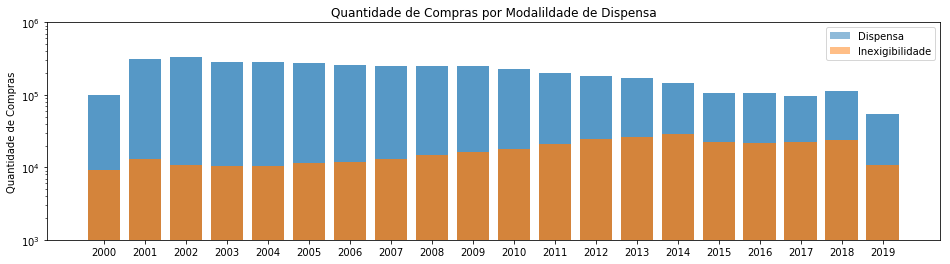

In [212]:
cod_6 = Query3[Query3.Modalidade == 6]
cod_7 = Query3[Query3.Modalidade == 7]

plt.figure(figsize=(16,4))
plt.title('Quantidade de Compras por Modalildade de Dispensa')
plt.ylabel('Quantidade de Compras')
plt.bar(cod_6.Ano.astype(str), cod_6['Quantidade de Compras'], alpha = .5, label = 'Dispensa')
plt.yscale('log')
plt.ylim(1e3, 1e6)
#plt.figure(figsize=(16,4))
plt.bar(cod_7.Ano.astype(str), cod_7['Quantidade de Compras'], alpha = .5, label = 'Inexigibilidade')
plt.legend()
plt.savefig('Query3.png')

In [215]:
Query3 = Query3.drop(['Modalidade'],axis = 1)
Query3.columns = ['Modalidade', 'Ano', 'Quantidade de Compras']
Query3.to_csv('resultado_query3.csv')

In [216]:
df.columns

Index(['Unnamed: 0', 'co_modalidade_licitacao', 'co_orgao', 'co_uasg',
       'ds_fundamento_legal', 'ds_justificativa', 'ds_objeto_licitacao',
       'dtDeclaracaoDispensa', 'dtPublicacao', 'dtRatificacao',
       'no_cargo_resp_decl_disp', 'no_cargo_resp_ratificacao',
       'no_responsavel_decl_disp', 'no_responsavel_ratificacao', 'nu_inciso',
       'nu_processo', 'vr_estimado'],
      dtype='object')

In [217]:
#resp_vr = df[['dtDeclaracaoDispensa', 'no_responsavel_decl_disp', 'no_cargo_resp_decl_disp', 'co_orgao', 'vr_estimado']]
resp_vr = df[['no_responsavel_decl_disp', 'no_cargo_resp_decl_disp', 'vr_estimado']]
#resp_vr['info'] = resp_vr.no_responsavel_decl_disp + ',' +  resp_vr.no_cargo_resp_decl_disp + ',' + resp_vr.co_orgao.astype(str)
#resp_vr.drop(['no_responsavel'])

In [219]:
Query4 = resp_vr.groupby(by = ['no_responsavel_decl_disp', 'no_cargo_resp_decl_disp']).agg(['count'])
Query4 = Query4['vr_estimado'].sort_values(by='count', ascending = False).reset_index()
Query4.columns = ['Responsável', 'Cargo', 'Quantidade']
Query4.to_csv('resultado_query4.csv')
Query4.head()

,Responsável,Cargo,Quantidade
0,FRANCISCO ROBERTO LEONARDO,Coordenador de Administra§¥o,7571
1,FLAVIO ANTONIO DOS SANTOS,Diretor Geral,6229
2,LUIZ ROBERTO SOUZA VIEIRA,Diretor de compras e licitacoes,6010
3,HUGO DA COSTA RIBEIRO JUNIOR,Diretor,5134
4,JORGE MARCOS SILVA CHAVES,Comprador,4522


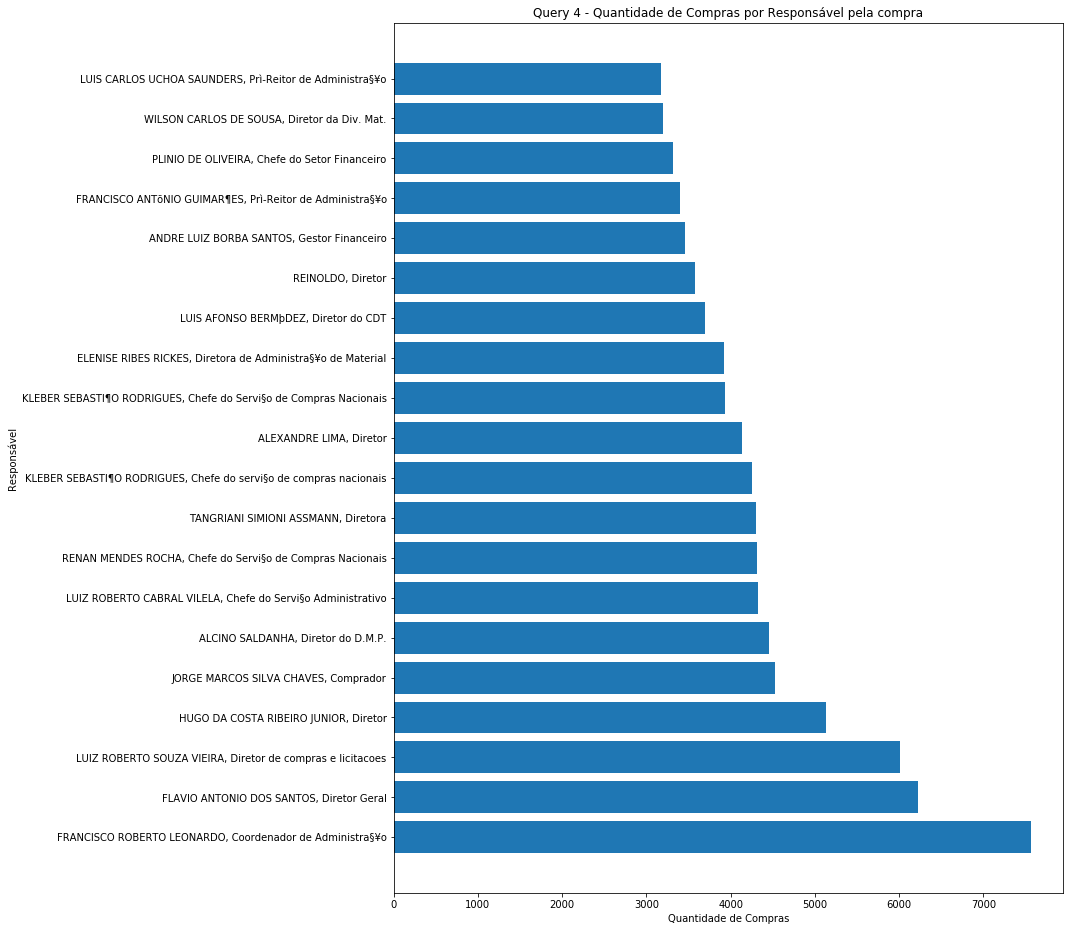

In [226]:
plt.figure(figsize=(12,16))
plt.barh(Query4['Responsável'][0:20] + ', ' + Query4['Cargo'][0:20], Query4['Quantidade'].values[0:20])
plt.title('Query 4 - Quantidade de Compras por Responsável pela compra')
plt.xlabel('Quantidade de Compras')
plt.ylabel('Responsável')
plt.savefig('Query4.png')

In [221]:
orgaos = pd.read_csv('data/orgaos.csv')
orgaos.head()

,Unnamed: 0,ativo,codigo,codigo_siorg,codigo_tipo_adm,codigo_tipo_esfera,codigo_tipo_poder,nome
0,0,True,1000,NaN,1,Federal,1,CAMARA DOS DEPUTADOS
1,1,True,1901,NaN,7,NaN,1,FUNDO ROTATIVO DA CAMARA DOS DEPUTADOS
2,2,True,2000,NaN,1,NaN,1,SENADO FEDERAL
3,3,True,2001,NaN,7,NaN,1,FUNDO ESPECIAL DO SENADO FEDERAL
4,4,True,2002,NaN,7,NaN,1,SENADO FEDERAL/FUNSEEP


In [222]:
orgao_vr = df[['co_orgao', 'vr_estimado']]
Query5 = orgao_vr.groupby(by = ['co_orgao']).sum()
Query5 = pd.merge(left=orgaos[['codigo', 'nome']], left_on='codigo', right=Query5, right_on='co_orgao')
Query5.columns = ['co_orgao','Órgão', 'Gastos']
Query5 = Query5.sort_values(by = 'Gastos', ascending = False)
Query5 = Query5.drop_duplicates('co_orgao')
Query5 = Query5.reset_index(drop = True)
Query5.to_csv('resultado_query5.csv')
Query5.head()

,co_orgao,Órgão,Gastos
0,36000,MINISTERIO DA SAUDE,6.976154e+10
1,52121,COMANDO DO EXERCITO,6.374591e+10
2,52111,COMANDO DA AERONAUTICA,2.750659e+10
3,36201,FUNDACAO OSWALDO CRUZ,2.684147e+10
4,26298,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,2.376398e+10


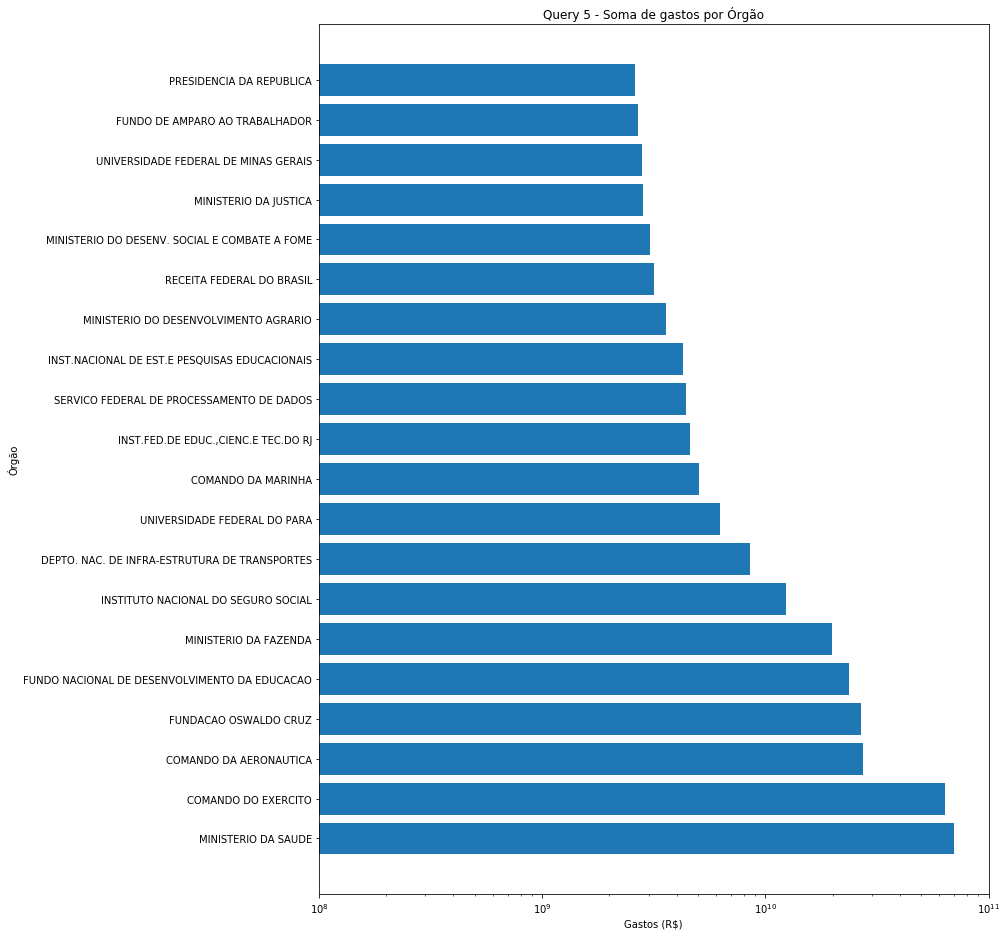

In [225]:
plt.figure(figsize=(12,16))
plt.barh(Query5['Órgão'].values[0:20], Query5.Gastos.values[0:20])
plt.title('Query 5 - Soma de gastos por Órgão')
plt.xlabel('Gastos (R$)')
plt.ylabel('Órgão')
plt.xscale('log')
plt.xlim(1e8,1e11)
plt.savefig('Query5.png')

In [41]:
Query1_B.columns = ['Mês', 'Valor Médio ($)']
Query1_B = Query1_B.reset_index()
Query1_B.columns = ['Ano', 'Mês', 'Valor Médio ($)']

ValueError: cannot insert dtDeclaracaoDispensa, already exists

,Mês,Valor Médio ($)
0,1,195948.945988
1,2,93144.493679
2,3,71629.540915
3,4,84340.612747
4,5,64426.933725
5,6,52423.678092
6,7,51954.324552
7,8,103232.421409
8,9,57445.883191
9,10,54811.176088


In [ ]:
csv_file = 'data/compras_slicitacoes.csv'
original_df = pd.read_csv(csv_file)

In [3]:
slice1 = original_df[(original_df.dtDeclaracaoDispensa >= '2016-01-01') & (original_df.dtDeclaracaoDispensa < '2017-01-01') ]

In [4]:
slice1.to_csv('data/compras_slicitacoes_2017.csv', sep = ';')

In [5]:
slice1.shape

(131136, 17)

In [8]:
del slice1

In [ ]:
# slice2 = original_df[(original_df.dtDeclaracaoDispensa >= '2016-01-01') & (original_df.dtDeclaracaoDispensa < '2019-01-01') ]

In [25]:
slice2.shape

(399180, 17)

In [9]:
top100_series = DataAnalysis.df.nlargest(100, ['vr_estimado']).copy()

In [10]:
top100_df = original_df.iloc[top100_series.id]

In [11]:
top100_df.head()

,Unnamed: 0,co_modalidade_licitacao,co_orgao,co_uasg,ds_fundamento_legal,ds_justificativa,ds_objeto_licitacao,dtDeclaracaoDispensa,dtPublicacao,dtRatificacao,no_cargo_resp_decl_disp,no_cargo_resp_ratificacao,no_responsavel_decl_disp,no_responsavel_ratificacao,nu_inciso,nu_processo,vr_estimado
303863,303863,7,52121,160399,"Fundamento Legal: Artigo 25 , Caput , da Le...","Justificativa: Competi§¥o © invi¤vel, uma vez ...",Objeto: Presta§¥o de servi§o de diagnìstico por,2005-08-01T00:00:00,2005-08-23T00:00:00,2005-08-03T00:00:00,Ordenador de Despesas do HGePA,Comandante da 3 Regi¥o Militar,GILMAR CORREA DE FIGUEIREDO,MARCO ANTONIO LONGO,0,INEX006/2005,1.800000e+10
416222,416222,7,52111,120006,"Fundamento Legal: Art. 25Ì, Caput da Lei nÌ 8....",Justificativa: Conforme Ata de Acordo nÊ004/DC...,Objeto: Aquisi§¥o de materiais e presta§¥o de ...,2014-05-16T00:00:00,2014-05-22T00:00:00,2014-05-21T00:00:00,Ordenador de Despesas Copac,Comandante da Aeron¤utica,JOSE AUGUSTO CREPALDI AFFONSO,JUNITI SAITO,0,008-13/COPAC,7.255869e+09
688924,688924,7,52121,160069,"Fundamento Legal: Art. 25Ì, Inciso I da Lei nÌ...",Justificativa: Inviabilidade de competi§¥o,Objeto: Aquisi§¥o de viatura blindada Guarani,2016-11-18T00:00:00,2016-11-21T00:00:00,2016-11-18T00:00:00,Ordenador de Despesas Substituto,Comandante Log­stico,MARCELO MORAES RODRIGUES,GUILHERME CALS THEOPHILO GASPAR DE OLIVEIRA,1,64447011981201620,5.939680e+09
547988,547988,7,52121,160085,"Fundamento Legal: Artigo 25, inciso I, da Lei ...",Justificativa: I- A empresa © produtora exclus...,"¥o do Ex©rcito Brasileiro, em conformidade com...",2009-12-15T00:00:00,2009-12-18T00:00:00,2009-12-16T00:00:00,Ordenador de Despesas do EME,Chefe de Gabinete do Estado-Maior do Exercito,CARLOS ALBERTO PASSARELLA ARANTES - CEL,GEN BDA CARLOS ROBERTO DE SOUSA PEIXOTO,1,12/200-EME,5.443227e+09
1443714,1443714,7,26239,150220,"Fundamento Legal: Art. 25Ì, Caput da Lei nÌ 8....",Justificativa: Fornecimento de PROTESE PARA IM...,Objeto: Fornecimento de PRøTESE PARA IMPLANTE ...,2016-01-04T00:00:00,2016-01-20T00:00:00,2016-01-04T00:00:00,Coordenador Administrativo,Diretor Geral,CELIO D ALBUQUERQUE NEVES FILHO,PAULO ROBERTO ALVES DE AMORIM,0,026380/2015,5.259618e+09


In [12]:
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('§', 'ç')
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('¥', 'ã')
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('©', 'é')
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('Ê', 'º')
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('¤', 'á')
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('Ì', 'º')
top100_df.loc[top100_df.index, 'ds_justificativa'] = top100_df.ds_justificativa.str.replace('ø', 'Ó')

top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('§', 'ç')
top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('¥', 'ã')
top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('©', 'é')
top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('Ê', 'º')
top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('¤', 'á')
top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('Ì', 'º')
top100_df.loc[top100_df.index, 'ds_fundamento_legal'] = top100_df.ds_fundamento_legal.str.replace('ø', 'Ó')

top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('§', 'ç')
top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('¥', 'ã')
top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('©', 'é')
top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('Ê', 'º')
top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('¤', 'á')
top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('Ì', 'º')
top100_df.loc[top100_df.index, 'ds_objeto_licitacao'] = top100_df.ds_objeto_licitacao.str.replace('ø', 'Ó')


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
orgao = pd.read_csv('data/orgaos.csv')
orgao_name = [orgao[orgao['codigo'] == c].nome.values[0] for c in top100_df.co_orgao]

uasgs = pd.read_csv('data/uasgs.csv')
uasgs_name = [uasgs[uasgs['id'] == c].nome.values[0] for c in top100_df.co_uasg]

top100_df['uasg'] = uasgs_name
top100_df['orgao'] = orgao_name
top100_df['dates'] = top100_series['dates'].values

top100_df = top100_df[
    ['dates', 
     'orgao', 
     'uasg', 
     'ds_fundamento_legal', 
     'ds_justificativa', 
     'ds_objeto_licitacao', 
     'no_cargo_resp_decl_disp',
     'no_responsavel_decl_disp', 
     'vr_estimado']
]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [14]:
top100_df.head()

,dates,orgao,uasg,ds_fundamento_legal,ds_justificativa,ds_objeto_licitacao,no_cargo_resp_decl_disp,no_responsavel_decl_disp,vr_estimado
303863,2005-08-01,COMANDO DO EXERCITO,HOSPITAL MILITAR DE ÁREA DE PORTO ALEGRE,"Fundamento Legal: Artigo 25 , Caput , da Le...","Justificativa: Competição é inviável, uma vez ...",Objeto: Prestação de serviço de diagnìstico por,Ordenador de Despesas do HGePA,GILMAR CORREA DE FIGUEIREDO,1.800000e+10
416222,2014-05-16,COMANDO DA AERONAUTICA,MAER-GAPBR-GRUPAMENTO DE APOIO DE BRASILIA/DF,"Fundamento Legal: Art. 25º, Caput da Lei nº 8....",Justificativa: Conforme Ata de Acordo nº004/DC...,Objeto: Aquisição de materiais e prestação de ...,Ordenador de Despesas Copac,JOSE AUGUSTO CREPALDI AFFONSO,7.255869e+09
688924,2016-11-18,COMANDO DO EXERCITO,COMANDO LOGISTICO,"Fundamento Legal: Art. 25º, Inciso I da Lei nº...",Justificativa: Inviabilidade de competição,Objeto: Aquisição de viatura blindada Guarani,Ordenador de Despesas Substituto,MARCELO MORAES RODRIGUES,5.939680e+09
547988,2009-12-15,COMANDO DO EXERCITO,ESTADO-MAIOR DO EXERCITO-MEX/DF,"Fundamento Legal: Artigo 25, inciso I, da Lei ...",Justificativa: I- A empresa é produtora exclus...,"ão do Exército Brasileiro, em conformidade com...",Ordenador de Despesas do EME,CARLOS ALBERTO PASSARELLA ARANTES - CEL,5.443227e+09
1443714,2016-01-04,UNIVERSIDADE FEDERAL DO PARA,HOSPITAL UNIVERSITÁRIO BETINA FERRO E SOUZA,"Fundamento Legal: Art. 25º, Caput da Lei nº 8....",Justificativa: Fornecimento de PROTESE PARA IM...,Objeto: Fornecimento de PRÓTESE PARA IMPLANTE ...,Coordenador Administrativo,CELIO D ALBUQUERQUE NEVES FILHO,5.259618e+09


In [15]:
string_columns = ['orgao',
                  'uasg',
                  'ds_fundamento_legal',
                  'ds_justificativa',
                  'ds_objeto_licitacao',
                  'no_cargo_resp_decl_disp',
                  'no_responsavel_decl_disp'
                 ]

for var in string_columns:
    top100_df[var] = [unidecode(w) for w in top100_df[var].values]

In [16]:
top100_df['dates'] = top100_df.dates.astype(str)

In [17]:
top100_df.head()

,dates,orgao,uasg,ds_fundamento_legal,ds_justificativa,ds_objeto_licitacao,no_cargo_resp_decl_disp,no_responsavel_decl_disp,vr_estimado
303863,2005-08-01,COMANDO DO EXERCITO,HOSPITAL MILITAR DE AREA DE PORTO ALEGRE,"Fundamento Legal: Artigo 25 , Caput , da Le...","Justificativa: Competicao e inviavel, uma vez ...",Objeto: Prestacao de servico de diagnistico por,Ordenador de Despesas do HGePA,GILMAR CORREA DE FIGUEIREDO,1.800000e+10
416222,2014-05-16,COMANDO DA AERONAUTICA,MAER-GAPBR-GRUPAMENTO DE APOIO DE BRASILIA/DF,"Fundamento Legal: Art. 25o, Caput da Lei no 8....",Justificativa: Conforme Ata de Acordo no004/DC...,Objeto: Aquisicao de materiais e prestacao de ...,Ordenador de Despesas Copac,JOSE AUGUSTO CREPALDI AFFONSO,7.255869e+09
688924,2016-11-18,COMANDO DO EXERCITO,COMANDO LOGISTICO,"Fundamento Legal: Art. 25o, Inciso I da Lei no...",Justificativa: Inviabilidade de competicao,Objeto: Aquisicao de viatura blindada Guarani,Ordenador de Despesas Substituto,MARCELO MORAES RODRIGUES,5.939680e+09
547988,2009-12-15,COMANDO DO EXERCITO,ESTADO-MAIOR DO EXERCITO-MEX/DF,"Fundamento Legal: Artigo 25, inciso I, da Lei ...",Justificativa: I- A empresa e produtora exclus...,"ao do Exercito Brasileiro, em conformidade com...",Ordenador de Despesas do EME,CARLOS ALBERTO PASSARELLA ARANTES - CEL,5.443227e+09
1443714,2016-01-04,UNIVERSIDADE FEDERAL DO PARA,HOSPITAL UNIVERSITARIO BETINA FERRO E SOUZA,"Fundamento Legal: Art. 25o, Caput da Lei no 8....",Justificativa: Fornecimento de PROTESE PARA IM...,Objeto: Fornecimento de PROTESE PARA IMPLANTE ...,Coordenador Administrativo,CELIO D ALBUQUERQUE NEVES FILHO,5.259618e+09


In [18]:
top100_df.reset_index(drop = True).to_json('json/100_maiores_gastos.json', orient = 'split', index = False)

In [19]:
top100_df.no_responsavel_decl_disp.value_counts()

EDUARDO SEARA MACHADO POJO DO REGO         20
ADHEMAR LOPES DE ALMEIDA                    3
ANDREA GOOD LIMA COUTO                      3
RUBENS PORTUGAL BACELLAR                    2
PEDRO AUGUSTO SANGUINETTI FERREIRA          2
GISELIA FERREIRA                            2
FABIO COIMBRA MIRANDA                       2
JOSE AUGUSTO CREPALDI AFFONSO               2
MARIANA NOGUEIRA DE RESENDE SOUSA           2
JULIANA MARCIA BARROSO                      2
ANToNIO MuRCIO DE OLIVEIRA AGUIAR           2
MAJ BRIG AR DIRCEU TONDOLO NoRO             2
ROBSON COCINO DA COSTA                      2
EUNICE DE OLIVEIRA FERREIRA SANTOS          2
ADRIANA RODOVALHO BEZERRA                   2
GUILHERME FERNANDO SCANDELAI                2
CINTIA NUNES CARDOSO LOPES                  1
PAULO ROBERTO DE ASSIS PASSOS               1
RUI ALENCAR ANDRADE                         1
JOPO 2NGELO LOURES                          1
VERA LthCIA DE MORAES                       1
LUCIA MARIA MODESTO PEREIRA       

In [36]:
with open('json/100_maiores_gastos.json', 'w', encoding='utf-8') as file:
    df3.reset_index(drop = True).to_json(file, orient = 'split', index = False)

## Datas
### Período de tempo utilizado: 2000-2019

In [6]:
print(DataAnalysis.df.dates.min())
print(DataAnalysis.df.dates.max())

2000-01-03 00:00:00
2019-08-02 00:00:00


## Análise Granular

In [7]:
months = [12,10,8,6,4,3,2,1]
days   = [20,15,12,10,9,7,5,3,1]

time_increment = list(zip(months, ['month']*len(months)))
time_increment += list(zip(days, ['day']*len(days)))

if not os.path.isfile('bckp/granulated_time_series.pkl'):
    for t in time_increment:
        print(t)
        times_temp = []
        n_vec_temp = []

        if t[1] == 'month':
            DataAnalysis.monthly_cumulative_time_series(2000, 1, t[0])
        if t[1] == 'day':
            DataAnalysis.cumulative_time_series('2000-01-01', pd.Timedelta(days = t[0]))
            
    DataAnalysis.save_history('bckp/granulated_time_series.pkl')
else:
    DataAnalysis.load_history('bckp/granulated_time_series.pkl')

## Decomposição Temporal

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
x, y = DataAnalysis.history['day', 1]
#y = [np.sum(i) for i in y]

In [10]:
out_df = pd.DataFrame()
out_df['date'] = x

try:
    out_df['mean'] = [np.mean(i) for i in y]
except:
    out_df['mean'] = 0
    
try:
    out_df['median'] = [np.median(i) for i in y]
except:
    out_df['median'] = 0

try:
    out_df['sum'] = [np.sum(i) for i in y]
except:
    out_df['sum'] = 0
    
try:
    out_df['std'] = [np.std(i) for i in y]
except:
    out_df['std'] = 0
    
try:
    out_df['max'] = [np.max(i) for i in y]
except:
    out_df['max'] = 0
    
try:
    out_df['min'] = [np.min(i) for i in y]
except:
    out_df['min'] = 0

out_df.to_csv('1_day_datagov.csv', index = False)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
series = pd.Series(y)
s_date = pd.Series(x)

series.index = pd.to_datetime(s_date)

In [12]:
from matplotlib.ticker import FormatStrFormatter
plt.style.use('ggplot')


import statsmodels.api as sm
import statsmodels.tsa as tsa
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import numpy as np
import stldecompose

#result = seasonal_decompose(series, model='additive', freq = 365)
result = stldecompose.stl.decompose(series, period = 2)
#cycle, trend = sm.tsa.filters.hpfilter(series, 365)

ValueError: setting an array element with a sequence.

In [ ]:
ylabel = 'Valor (R$)'

fig, ax = plt.subplots(4,1, figsize = (20,16))
fig.tight_layout() 

ax[0].plot(series, linewidth = 4)
ax[0].set_title('Total Revenue', fontsize = 30)
ax[0].set_ylabel(ylabel, fontsize = 25)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax[0].xaxis.grid(color = 'blue')

ax[1].plot(result.trend, linewidth = 4)
ax[1].set_title('Trend', fontsize = 30)
ax[1].set_ylabel(ylabel, fontsize = 25)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax[1].xaxis.grid(color = 'blue') # horizontal lines

ax[2].plot(result.seasonal, linewidth = 4)
ax[2].set_title('Seasonal (Anual)', fontsize = 30)
ax[2].set_ylabel(ylabel, fontsize = 25)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax[2].xaxis.grid(color = 'blue') # horizontal lines

ax[3].plot(result.resid, linewidth = 4)
ax[3].set_title('Seasonal (Anual)', fontsize = 30)
ax[3].set_ylabel(ylabel, fontsize = 25)
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax[3].xaxis.grid(color = 'blue') # horizontal lines
fig.subplots_adjust(hspace=.2)


In [ ]:
plt.figure(figsize=(16,4))
plt.plot(series)
plt.plot(result.seasonal + result.trend)
#plt.xlim('01-01-2000','01-01-2006')
#plt.ylim(0,1e8)

In [ ]:
seasonal = pd.DataFrame(result.seasonal)
seasonal.columns = ['values']

trend = pd.DataFrame(result.trend)
trend.columns = ['values']

In [ ]:
dow = []
months = []
for i in result.seasonal.index:
    months.append(i.month)
    dow.append(i.dayofweek)

In [ ]:
seasonal['months'] = months
seasonal['dow'] = dow

trend['months'] = months
trend['dow'] = dow

In [ ]:
h = np.array([v[0] for v in seasonal.groupby('months').mean().values])
m = np.array([v[0] for v in trend.groupby('months').mean().values])

plt.figure(figsize=(16,4))
plt.bar(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dec'], m+h)

In [ ]:
h = np.array([v[0] for v in seasonal.groupby('dow').mean().values])
m = np.array([v[0] for v in trend.groupby('dow').mean().values])

plt.figure(figsize=(16,4))
plt.bar(['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], m+h)
#plt.ylim(1.2e7)

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
# fit model
dt = series
model = ARIMA(dt, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(dt)-1, len(dt)+10, typ='levels')

plt.figure(figsize = (16,4))
plt.plot(series.values)
plt.plot(list(range(len(dt), len(dt)+len(yhat))),yhat)

In [ ]:
import pyramid
#https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

In [ ]:
from pyramid.arima import auto_arima
model = auto_arima(series, trace=True, error_action='ignore', suppress_warnings=True)

In [ ]:
model = auto_arima(y_train, start_p=0, start_q=0,
            test='adf',       
            max_p=7, max_q=7, 
            m=np.int(season),             
            d=n_diffs,           
            seasonal=True,  
            start_P=0, 
            D=1, 
            trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True)

print(model.conf_int())
y_forec, conf_int  = model.predict(10,return_conf_int=True,alpha=0.05)
print(conf_int)
std_error = model.bse()

In [ ]:
#result = seasonal_decompose(series, model='additive', freq = 30)
result = stldecompose.stl.decompose(series, period = 30)

ax[3].plot(result.seasonal, linewidth = 4)
ax[3].set_title('Seasonal (Month)', fontsize = 30)
ax[3].set_ylabel(ylabel, fontsize = 25)
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax[3].xaxis.grid(color = 'blue') # horizontal lines

#result = seasonal_decompose(series, model='additive', freq = 7)
result = stldecompose.stl.decompose(series, period = 7)

ax[4].plot(result.seasonal, linewidth = 4)
ax[4].set_title('Seasonal (Week)', fontsize = 30)
ax[4].set_ylabel(ylabel, fontsize = 25)
ax[4].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
ax[4].xaxis.grid(color = 'blue') # horizontal lines

#ax[3].plot(result.resid, linewidth = 4)
#ax[3].set_title('Residual', fontsize = 30)
#ax[3].set_ylabel(ylabel, fontsize = 25)
#ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2E'))
#ax[3].xaxis.grid(color = 'blue') # horizontal lines

fig.subplots_adjust(hspace=.8)
   
for i in range(5):
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(20) 
    for tick in ax[i].get_yticklabels():
        tick.set_fontsize(20) 
        
        
plt.show()

## Análise de Complexidade

In [8]:
from modules.complexity_analytics import Chronometer
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [18]:
times = []
input_sizes = []

for day, month in time_increment:
    print(month,day)
    
    x, y = DataAnalysis.history[month, day]
    
    y = [np.median(v) for v in y]
    y = np.nan_to_num(y, 0)
    
    x = np.linspace(0, len(y), num=len(y), endpoint=True)
    
    
    #parameters = {'x':x,
    #              'y':y,
    #              'kind':'cubic',
    #              'fill_value':'extrapolate'
    #             }
    
    parameters = {'x':x,
                  'y':y,
                  'extrapolate': 'periodic'
                 }

    chron_spline = Chronometer(CubicSpline, parameters, int(1e4))
    chron_spline.start()
    times.append(chron_spline.result['time'])
    input_sizes.append(len(y))

month 12
month 10
month 8
month 6
month 4
month 3
month 2
month 1
day 20
day 15
day 12
day 10
day 9
day 7
day 5
day 3


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


day 1


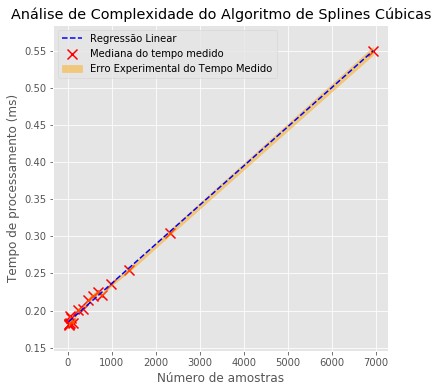

In [26]:
plt.style.use('ggplot')
x = [v for v in input_sizes]
y = np.array([np.mean(t) for t in times])
std = np.array([np.std(t)*2/(len(t)**.5) for t in times])
y_M = y+std
y_m = y-std

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(6,6))
plt.scatter(x, y*1000, marker = 'x', s = 100, color = 'red', label = 'Mediana do tempo medido')
plt.fill_between(x, y_M*1000, y_m*1000, color = 'orange', alpha = .45, label = 'Erro Experimental do Tempo Medido')

plt.plot(x, p(x)*1000, '--', color = 'blue', label = 'Regressão Linear')
plt.legend()
plt.xlabel('Número de amostras')
plt.ylabel('Tempo de processamento (ms)')
plt.title('Análise de Complexidade do Algoritmo de Splines Cúbicas')
plt.savefig('comp_spline.png')
print()

In [20]:
import scipy 
times = []
input_sizes = []
chron_fft = None
x, y = None, None
parameters = None

for day, month in time_increment:
    print(month,day)
    del x, y
    del chron_fft
    del parameters
    
    x, y = DataAnalysis.history[month, day]

    y = [np.median(v) for v in y]
    y = np.nan_to_num(y, 0)
    
    x = np.linspace(0, len(y), num=len(y), endpoint=True)
    
    
    parameters = {
                  'a':y,
                 }

    chron_fft = Chronometer(np.fft.fft, parameters, int(1e4))
    chron_fft.start()
    times.append(chron_fft.result['time'])
    input_sizes.append(len(y))
    
s = CubicSpline(x, y, extrapolate='periodic')
for i in range(2,21):
    print(i)
    xnew = np.linspace(0, len(y), num=len(y)*i, endpoint=True)
    y_ = s(xnew)
    
    parameters = {
                  'a':y_,
                 }

    chron_fft = Chronometer(np.fft.fft, parameters, int(1e4))
    chron_fft.start()
    times.append(chron_fft.result['time'])
    input_sizes.append(len(y_))

month 12
month 10
month 8
month 6
month 4
month 3
month 2
month 1
day 20
day 15
day 12
day 10
day 9
day 7
day 5
day 3


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


day 1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


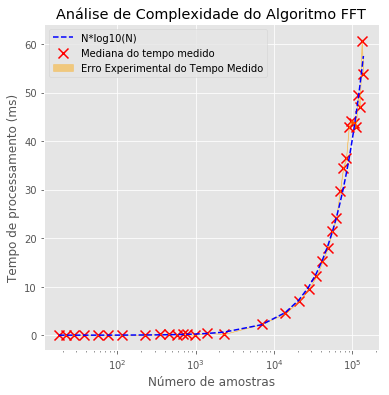

In [28]:
plt.style.use('ggplot')
x = [v for v in input_sizes]
y = np.array([np.median(t) for t in times])
std = np.array([np.std(t)*2/(len(t)**.5) for t in times])
y_M = y+std
y_m = y-std

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(6,6))
plt.scatter(x, y*1000, marker = 'x', s = 100, color = 'red', label = 'Mediana do tempo medido')
plt.fill_between(x, y_M*1000, y_m*1000, color = 'orange', alpha = .45, label = 'Erro Experimental do Tempo Medido')

x = np.array(x)
plt.plot(x, 0.000035*x*np.log(x), '--', color = 'blue', label = 'N*log10(N)')
plt.legend()
plt.xlabel('Número de amostras')
plt.ylabel('Tempo de processamento (ms)')
plt.title('Análise de Complexidade do Algoritmo FFT')
plt.xscale('log')
plt.savefig('comp_fft.png')
print()